## Neural Style Transfer (Transferencia de Estilo Neuronal)

* Fué presentada por [Leon A. Gatys, Alexander S. Ecker, and Matthias Bethge, “A Neural Algorithm of Artistic Style,” arXiv (2015)](https://arxiv.org/abs/1508.06576)
* Consiste en **aplicar el estilo de una imagen de referencia** a **una imagen de destino conservando el contenido de la imagen de destino**:

**Usaremos el "Starry Night" de Vincent Van Gogh**

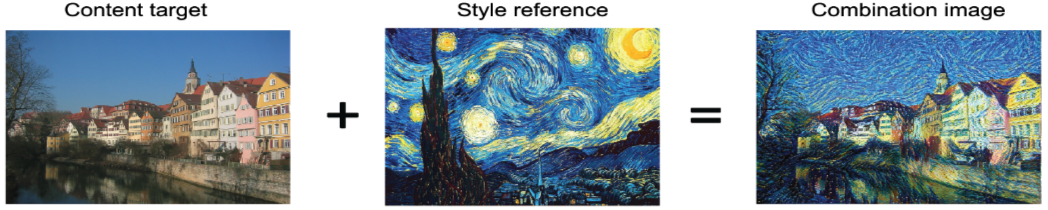

* **Estilo(style)** significa: **texturas**, **colores** y **patrones visuales** de la imagen, en **varias escalas espaciales** (pinceladas circulares azules y amarillas)
* **Contenido(content)** es la **macroestructura de nivel superior de la imagen** (los edificios de la fotografía de Tübingen)
* **Noción clave**: define una **función de pérdida** para **especificar lo que desea lograr** y **minimiza esta pérdida**. 
* Sabemos lo que queremos conseguir: **conservar el contenido de la imagen original pero adoptando el estilo de la imagen de referencia**. Si pudiéramos **definir matemáticamente el contenido** y el **estilo**, entonces una **funci**ón de pérdida apropiada para minimizar sería la siguiente:

In [ ]:
loss = (distance(style(reference_image) - style(combination_image)) +
        distance(content(original_image) - content(combination_image)))

* **distancia**: función de norma como la **norma L2**
* **contenido**: **función(imagen) -> representación de su contenido**
* **estilo** -> función(imagen) -> **representación de su estilo** 
* **Minimizar esta pérdida** hace que el ``style(combination_image)`` esté cerca del ``style(reference_image)`` y el ``content(combination_image)`` esté cerca del ``content(original_image)``, **logrando así la transferencia de estilo**. 
* Observación fundamental del paper: **las redes neuronales convolucionales profundas ofrecen una forma de definir matemáticamente las funciones de estilo y contenido**:

### La 'content loss'

* Las **diferentes capas** de una **convnet** proporcionan una **descomposición** de los **contenidos** de una imagen **en diferentes escalas espaciales**. Esto es:
  * **Primeras capas** de una red contienen **información local** sobre la imagen
  * **Capas más profundas** contienen información **abstracta** cada vez **más global** ->  Un buen candidato para la **pérdida de contenido** sería la **norma L2** entre: 
    * las **activaciones de una capa superior en un convnet preentrenada**, calculadas sobre la **imagen target** (fotografía de Tübingen)
    * las **activaciones de la misma capa** calculadas sobre la **imagen generada** (combination image). 
  
    Esto garantiza que, **vista desde la capa superior**, la **imagen generada** (combination image) se verá **similar** a la **imagen target original** (fotografía de Tübingen) -> Esto funciona como una forma de **preservar el contenido de la imagen**.

### La 'style loss'

* La **'content loss'** solo utiliza una única capa superior
* La **'style loss'** utiliza **varias capas de una convnet**: **captura la apariencia** de la **imagen de referencia de estilo** en **todas las escalas espaciales extraídas por la convnet**
* Para la **'style loss'** se usa la **matriz de Gram** de las **activaciones de una capa**: el **producto** interno de los **mapas de características de una capa dada**. El resultado puede entenderse como la **representación de un mapa de las correlaciones entre las características de la capa**. 
* Estas **correlaciones** de características **capturan las estadísticas de los patrones de una escala espacial particular**, la **apariencia de las texturas encontradas en esta escala**. 
* Por tanto, la **'style loss'** tiene como objetivo **preservar correlaciones internas similares dentro de las activaciones de diferentes capas**, a través de la **imagen de referencia de estilo** ("Starry Night" de Vincent Van Gogh) **y la imagen generada** (combination image). 
* Además, garantiza que las **texturas encontradas en diferentes escalas espaciales** se **vean similares** en la **imagen de referencia de estilo** y la **imagen generada**. 

En resumen, **usamos una convnet preentrenada para definir una pérdida que hará lo siguiente**: 
* **Preservar el contenido manteniendo activaciones de capa de alto nivel similares entre la imagen original y la imagen generada**. Las capas más profundas de la convnet deberían "ver" tanto la imagen original como la imagen generada como si contuvieran las mismas cosas. 
* **Preservar el estilo manteniendo correlaciones similares dentro de las activaciones tanto para las capas de bajo nivel como para las capas de alto nivel**. Las **correlaciones de características capturan texturas**: la **imagen generada** y la **imagen de referencia de estilo** deben **compartir las mismas texturas en diferentes escalas espaciales**. 

Lo implementamos en Keras:

### Neural Style Transfer en Keras

**Neural Style Transfer** se puede **implementar** utilizando **cualquier convnet preentrenada**. Nosotros usaremos la red **VGG19**. Este es el proceso general: 
* Configuramos una red que calcule las **activaciones de capa VGG19** para la **imagen de referencia de estilo**, la **imagen base** y la **imagen generada** al **mismo tiempo**. 
* Usamos las activaciones de capa calculadas sobre estas tres imágenes para **definir la función de pérdida**, que **minimizaremos para lograr la transferencia de estilo**. 
* **Configuraremos** un proceso de **descenso de gradiente para minimizar esta función de pérdida**. 

Como si los tamaños de las imágenes son muy diferentes dificultan la transferencia de estilo, **cambiaremos el tamaño de todas a una altura de 400 px**.

**Obtener las imágenes de estilo y contenido**

In [1]:
from tensorflow import keras

# Path a la imagen que queremos transformar
base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
# Path a la imagen de estilo
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
# Dimensiones de la imagen generada
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 0s 0us/step


**Content image: San Francisco from Nob Hill**

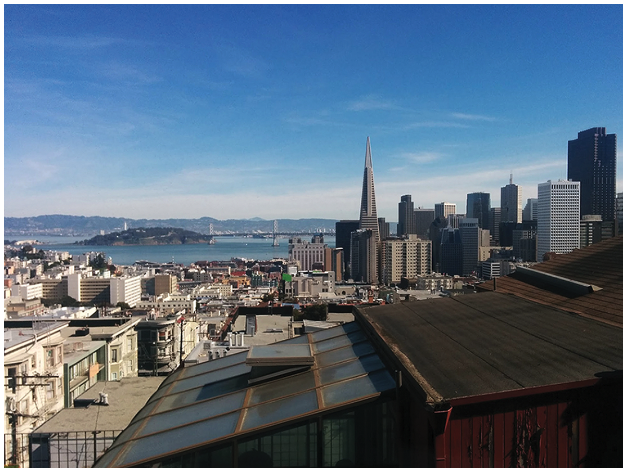

**Style image: Starry Night by Van Gogh**

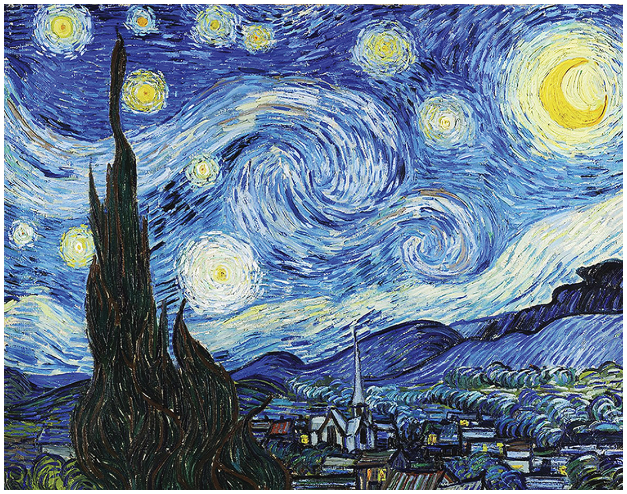

**Funciones Auxiliares**

Funciones auxiliares necesarias para **cargar**, **preprocesar** y **posprocesar** las imágenes que **entran** y **salen** de la **convnet VGG19**

In [2]:
import numpy as np

# Función útil para abrir, cambiar el tamaño y 
# formatear imágenes en sus matrices correspondientes
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# Función útil para convertir una matriz NumPy en una imagen válida
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # Centrado a cero mediante la eliminación del valor 
    # de píxel medio de ImageNet. Esto invierte una 
    # transformación realizada por vgg19.preprocess_input
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # Convierte imágenes de 'BGR' a 'RGB'. Esto también es 
    # parte de la reversión de lo hecho por vgg19.preprocess_input
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Uso de un modelo VGG19 preentrenado para crear un extractor de características**

**Configuramos** la red **VGG19**. Al igual que en el ejemplo de DeepDream, **usaremos** el **convnet preentrenado** para **crear un modelo extractor de características** que **devuelva** las **activaciones** de **todas las capas del modelo**.

In [3]:
# Creamos un modelo VGG19 cargado con pesos preentrenados con ImageNet
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Modelo que devuelve los valores de activación 
# para cada capa de destino (como un diccionario)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


**Pérdida de contenido**

Definimos la **'content loss'**, que garantizará que la **capa superior de la convnet VGG19 tenga una vista similar de la imagen de estilo** y la **combination image**

In [4]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**Pérdida de estilo**

Lo siguiente es la **'style loss'**. Utiliza una función auxiliar para **calcular la matriz de Gram** de una **matriz de entrada**: un **mapa de las correlaciones encontradas en la matriz de características original**.

In [5]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Pérdida de Variación Total**

A estos dos componentes de pérdida, **se suma un tercero**: la **pérdida de variación total**, que **opera sobre los píxeles de la imagen combinada generada**. **Fomenta la continuidad espacial en la imagen generada, evitando así resultados excesivamente pixelados**. Podemos interpretarlo como una **pérdida de regularización**.

In [6]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Definición de la pérdida final que minimizaremos**

La **pérdida que minimizamos** es un **promedio ponderado de estas tres pérdidas**. Para calcular la **'content loss'**, usamos solo **una capa superior**, la capa ``block5_conv2``, mientras que para la **'style loss'**, usamos una **lista de capas que abarca capas de bajo y alto nivel**. **Agregamos la pérdida de variación total al final**. 

Según la **imagen de referencia de estilo** y la **imagen de conteni**do que estemos utilizando, es probable que deseemos **ajustar el coeficiente ``content_weight``** (la c**ontribución de la 'content loss' a la pérdida total**). Un **``content_weight``** más **alto** significa que el **contenido de destino será más reconocible en la imagen generada**.

In [7]:
# Lista de capas a usar para la 'style loss'
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# La capa a usar para la 'content loss'
content_layer_name = "block5_conv2"
# Peso de la contribución de la pérdida de variación total
total_variation_weight = 1e-6
# Peso de la contribución de la 'style loss'
style_weight = 1e-6
# Peso de la contribución de la 'content loss'
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    # Inicializamos la pérdida a 0
    loss = tf.zeros(shape=())
    # Agrega la 'content loss'
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Añade la 'style loss'    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    # Añade la pérdida de variación total.
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Configuración del proceso de descenso de gradiente**

* Finalmente, **configuramos** el proceso de **descenso de gradiente** de **mini lotes** con el **optimizador ``SGD``** (en el paper, se usó L-BFGS, pero no está disponible en TensorFlow)
* Aprovecharemos una característica del optimizador: **learning-rate schedule**. Esto **disminuirá gradualmente la tasa de aprendizaje** desde un **valor muy alto (100)** a un **valor final mucho más pequeño** (alrededor de **20**). Así **progresará rápidamente en las primeras etapas del entrenamiento** y luego **procederá con más cautela a medida que nos acerquemos al mínimo de pérdidas**.

In [8]:
import tensorflow as tf

# Hacemos que el paso de entrenamiento sea 
# rápido al compilarlo como una función tf.
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    # Comenzaremos con una tasa de aprendizaje de 100 
    # y la disminuiremos en un 4 % cada 100 pasos.
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# Usamos una variable para almacenar la imagen combinada, 
# ya que la actualizaremos durante el entrenamiento.
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # Actualizamos la imagen combinada en una dirección que 
    # reduzca la pérdida de transferencia de estilo.
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        # Guardamos la imagen combinada a intervalos regulares.
        keras.utils.save_img(fname, img)

Iteration 100: loss=8136.16
Iteration 200: loss=6651.91
Iteration 300: loss=6062.22
Iteration 400: loss=5741.40
Iteration 500: loss=5535.43
Iteration 600: loss=5390.23
Iteration 700: loss=5280.86
Iteration 800: loss=5195.34
Iteration 900: loss=5126.33
Iteration 1000: loss=5069.42
Iteration 1100: loss=5021.49
Iteration 1200: loss=4980.61
Iteration 1300: loss=4945.27
Iteration 1400: loss=4914.51
Iteration 1500: loss=4887.42
Iteration 1600: loss=4863.34
Iteration 1700: loss=4841.78
Iteration 1800: loss=4822.41
Iteration 1900: loss=4805.03
Iteration 2000: loss=4789.28
Iteration 2100: loss=4774.98
Iteration 2200: loss=4761.88
Iteration 2300: loss=4749.86
Iteration 2400: loss=4738.76
Iteration 2500: loss=4728.47
Iteration 2600: loss=4718.95
Iteration 2700: loss=4710.14
Iteration 2800: loss=4701.98
Iteration 2900: loss=4694.40
Iteration 3000: loss=4687.31
Iteration 3100: loss=4680.69
Iteration 3200: loss=4674.51
Iteration 3300: loss=4668.74
Iteration 3400: loss=4663.31
Iteration 3500: loss=46

* Mostramos el resultado. Lo que **logramos con esta esta técnic**a es simplemente una forma de **retexturización de imágenes** o **transferencia de texturas**. 
* Funciona **mejor con imágenes de referencia de estilo** con **mucha textura** y **son muy similares entre ellas**, y con **objetivos de contenido** que **no requieren altos niveles de detalle para ser reconocibles**. 
* El **algoritmo** está más **cerca** del **procesamiento de señales clásico que de la IA**, ¡así que no esperéis que funcione como magia!

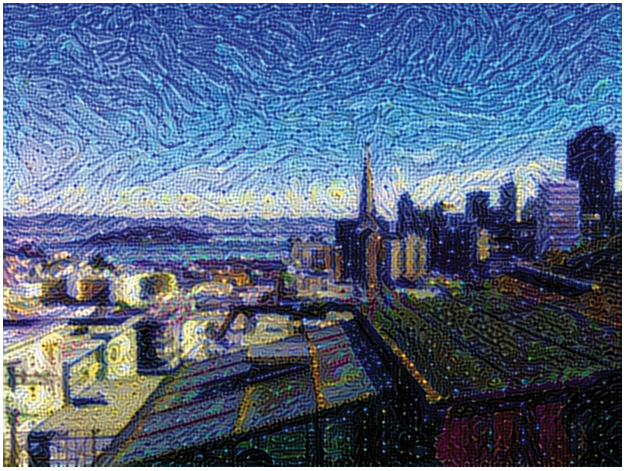

* Este algoritmo de transferencia de estilo es **lento de ejecutar**, pero es lo **suficientemente simple** como para que también pueda ser aprendida por una pequeña y rápida convnet de retroalimentación (**fast feedforward convnet**)
* Se puede lograr una **transferencia de estilo rápida** gastando primero una **gran cantidad de ciclos de cómputo para generar ejemplos de entrenamiento de entrada y salida para una imagen de referencia de estilo fijo**, utilizando el método descrito aquí, y luego **entrenando una convnet simple para aprender esta transformación específica de estilo**. Una vez hecho esto, estilizar una imagen dada, es instantáneo: es **solo un paso hacia adelante de este pequeño convnet**.

### Resumiendo

* La **transferencia de estilo** consiste en **crear una nueva imagen que conserva el contenido de una imagen target y al mismo tiempo captura el estilo de una imagen de referencia**
* El **contenido** puede ser **capturado por las activaciones de alto nivel de una convnet**.
* El **estilo** puede ser **capturado por las correlaciones internas de las activaciones de diferentes capas de un convnet**.
* Por lo tanto, el aprendizaje profundo permite que la **transferencia de estilos** se formule como un **proceso de optimización** utilizando una **pérdida definida con una convnet preentrenada**.
* Partiendo de esta idea básica, **son posibles muchas variantes y mejoras**.